In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import sklearn

import requests
import json

import matplotlib.pyplot as plt
import mplcyberpunk
from matplotlib import rc
import seaborn as sns

plt.style.use('cyberpunk')

plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings(action='ignore')

### Step 1. 데이터 수집 및 전처리

In [28]:
from fredapi import Fred
import os

# FRED API 호출
FRED_API_KEY = os.getenv('FRED_API_KEY')
fred = Fred(api_key=FRED_API_KEY)
start_date = '1980-01-01'
end_date = '2024-12-31'

interest_payments = fred.get_series("A091RC1Q027SBEA") #Billions of Dollars
gdp = fred.get_series("GDP") #Billions of Dollars
dept = fred.get_series("GFDEBTN") #Millions of Dollars

interest_payments_to_gdp = interest_payments / gdp
dept_to_gdp = dept / gdp / 1000



In [88]:

url = "https://api.coinmarketcap.com/data-api/v3/cryptocurrency/detail/chart?id=1&range=5y&convertId=2798"
res = requests.get(url)
res

<Response [200]>

cryptos.json

In [101]:
url = "https://api.coinmarketcap.com/data-api/v3/cryptocurrency/detail/chart?id=1&timeStart=1633910400&timeEnd=1704931200"
res = requests.get(url)
bitcoin_price = res.json()['data']['points']
bitcoin_price
#[datetime.fromtimestamp(int(x)) for x in list(res.json()['data']['points'].keys())]

{'1279065600': {'v': [0.05815725, 261.54, 196180.04855025, 1, 3373269.0],
  'c': [0.05815725, 261.54, 196180.04855025]},
 '1279756800': {'v': [0.07417871, 2167.06, 258429.35330125, 1, 3483875.0],
  'c': [0.07417871, 2167.06, 258429.35330125]},
 '1280448000': {'v': [0.06373855, 3013.58, 226974.82496795, 1, 3561029.0],
  'c': [0.06373855, 3013.58, 226974.82496795]},
 '1281052800': {'v': [0.06076835, 1397.31, 221016.00815875, 1, 3637025.0],
  'c': [0.06076835, 1397.31, 221016.00815875]},
 '1281744000': {'v': [0.06290812, 4404.59, 234085.832629, 1, 3721075.0],
  'c': [0.06290812, 4404.59, 234085.832629]},
 '1282348800': {'v': [0.06581683, 10441.99, 248585.23064775, 1, 3776925.0],
  'c': [0.06581683, 10441.99, 248585.23064775]},
 '1283040000': {'v': [0.0667281, 3161.99, 257261.8485375, 1, 3855375.0],
  'c': [0.0667281, 3161.99, 257261.8485375]},
 '1283644800': {'v': [0.0599639, 8470.29, 234649.2343825, 1, 3913175.0],
  'c': [0.0599639, 8470.29, 234649.2343825]},
 '1284336000': {'v': [0.0601

In [ ]:
bitcoin

In [120]:
data = {datetime.fromtimestamp(int(k)):v['v'] for k,v in bitcoin_price.items()}

df = pd.DataFrame(index=data.keys(), data=data.values(), columns=['price', 'volume', 'market_cap','-','supply'])
df

,price,volume,market_cap,-,supply
2010-07-14 09:00:00,0.058157,2.615400e+02,1.961800e+05,1.0,3373269.0
2010-07-22 09:00:00,0.074179,2.167060e+03,2.584294e+05,1.0,3483875.0
2010-07-30 09:00:00,0.063739,3.013580e+03,2.269748e+05,1.0,3561029.0
2010-08-06 09:00:00,0.060768,1.397310e+03,2.210160e+05,1.0,3637025.0
2010-08-14 09:00:00,0.062908,4.404590e+03,2.340858e+05,1.0,3721075.0
...,...,...,...,...,...
2024-12-03 09:00:00,95854.597434,6.706781e+10,1.896613e+12,1.0,19786351.0
2024-12-11 09:00:00,96656.061618,8.539141e+10,1.913271e+12,1.0,19794629.0
2024-12-18 09:00:00,106147.295260,9.386566e+10,2.104021e+12,1.0,19821710.0
2024-12-26 09:00:00,99297.697009,4.705498e+10,1.966288e+12,1.0,19801945.0


<AxesSubplot:>

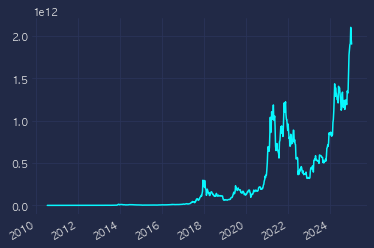

In [129]:
df['market_cap'].plot()

- 1t은 35274oz
- 연간 채굴량 약 3600t(분기별 900t)
- oz로 환산하면 연간 1,269,842,400oz, 분기별 31,746,600oz
- 현재(25.1.3 기준) 금은 온스(oz)당 2,634$
- 현재(25 기준) 총 금 채굴량 201,296t, 온스로 환산하면 7,100,515,104
- 시가총액은 18,702,756,783,936$  (18 trillion dollar)


In [137]:
url = 'https://fsapi.gold.org/api/v11/charts/supply-and-demand/35'

res = requests.get(url)

In [153]:
data.keys()

dict_keys(['categories', 'series'])

In [173]:
data = res.json()['chartData']['Supply_Quarterly']

df_gld = pd.DataFrame({
    'date':data['categories'],
    'mine_production':data['series'][0]['data'],
    'price/oz': data['series'][-1]['data']
})
df_gld['date'] = df_gld['date'].apply(lambda x : '20'+x[-2:]+x[:2])
df_gld['date'] = df_gld['date'].apply(lambda x : pd.Period(x, freq='Q').to_timestamp())
df_gld = df_gld.set_index('date')

df_gld

,mine_production,price/oz
date,,
2010-01-01,632.000,1109.1
2010-04-01,674.598,1196.7
2010-07-01,729.703,1226.8
2010-10-01,718.165,1366.8
2011-01-01,667.553,1386.3
2011-04-01,719.680,1506.1
2011-07-01,752.679,1702.1
2011-10-01,736.950,1688.0
2012-01-01,685.842,1690.6


In [185]:
data_ourworld = requests.get("https://api.ourworldindata.org/v1/indicators/66252.metadata.json").json()['dimensions']

In [195]:
years = [x['id'] for x in data_ourworld['years']['values']]

In [196]:
len(years)

335

In [198]:
requests.get("https://api.ourworldindata.org/v1/indicators/66252.metadata.json").json()

{'id': 66252,
 'name': 'Gold Production (Clio-Infra & USGS)',
 'unit': 'metric tons',
 'description': 'Gold mine production measured in metric tons. Clio infra data up until 2012 and 2013 onwards uses USGS data.',
 'createdAt': '2017-12-14T15:32:33.000Z',
 'updatedAt': '2023-06-15T05:05:42.000Z',
 'coverage': '',
 'timespan': '',
 'datasetId': 919,
 'columnOrder': 0,
 'dataPath': 'https://api.ourworldindata.org/v1/indicators/66252.data.json',
 'metadataPath': 'https://api.ourworldindata.org/v1/indicators/66252.metadata.json',
 'datasetName': 'Metal production - Clio Infra & USGS',
 'type': 'int',
 'nonRedistributable': False,
 'display': {'unit': 'metric tons', 'shortUnit': 'tons'},
 'source': {'id': 6729,
  'name': 'Metal production - Clio Infra & USGS',
  'dataPublishedBy': 'Metal production - Clio Infra & USGS',
  'dataPublisherSource': 'Historical data, census data, and geological surveys',
  'link': 'https://www.clio-infra.eu/ and https://minerals.usgs.gov/minerals/pubs/commodity/

In [207]:
data_ourworld = requests.get('https://api.ourworldindata.org/v1/indicators/66252.data.json').json()
data_ourworld_values = data_ourworld['values']
data_ourworld_entities = data_ourworld['entities']
data_ourworld_years = data_ourworld['years']

In [211]:
len(data_ourworld_values), len(data_ourworld_entities), len(data_ourworld_years)

(36478, 36478, 36478)

In [214]:
df_ourworld = pd.DataFrame(data={
    'years':data_ourworld_years,
    'entities': data_ourworld_entities, 
    'values': data_ourworld_values})

- https://ourworldindata.org/grapher/gold-production

In [223]:
df_gld.resample('y').sum()

,mine_production,price/oz
date,,
2010-12-31,2754.466,4899.4
2011-12-31,2876.862,6282.5
2012-12-31,2957.201,6673.9
2013-12-31,3167.336,5649.1
2014-12-31,3271.731,5064.8
2015-12-31,3362.374,4641.7
2016-12-31,3516.242,4998.6
2017-12-31,3580.564,5029.4
2018-12-31,3658.415,5074.8


In [240]:
total_gld_2009 = (df_ourworld.groupby('years').agg('sum')/2).cumsum().loc[2009]['values']
total_gld_2009

142897.0

In [243]:
df_gld['mine_total'] = df_gld['mine_production'].cumsum() + total_gld_2009
df_gld

,mine_production,price/oz,mine_total
date,,,
2010-01-01,632.000,1109.1,143529.000
2010-04-01,674.598,1196.7,144203.598
2010-07-01,729.703,1226.8,144933.301
2010-10-01,718.165,1366.8,145651.466
2011-01-01,667.553,1386.3,146319.019
2011-04-01,719.680,1506.1,147038.699
2011-07-01,752.679,1702.1,147791.378
2011-10-01,736.950,1688.0,148528.328
2012-01-01,685.842,1690.6,149214.170


<AxesSubplot:xlabel='date'>

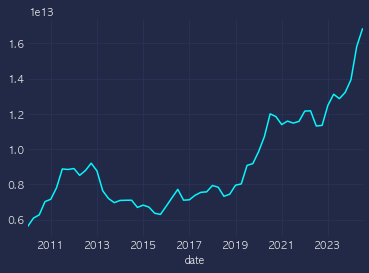

In [246]:
(df_gld['price/oz']*df_gld['mine_total']*35274).plot()

In [203]:
data_ourworld['years']['values']

[{'id': 1681},
 {'id': 1682},
 {'id': 1683},
 {'id': 1684},
 {'id': 1685},
 {'id': 1686},
 {'id': 1687},
 {'id': 1688},
 {'id': 1689},
 {'id': 1690},
 {'id': 1691},
 {'id': 1692},
 {'id': 1693},
 {'id': 1694},
 {'id': 1695},
 {'id': 1696},
 {'id': 1697},
 {'id': 1698},
 {'id': 1699},
 {'id': 1700},
 {'id': 1701},
 {'id': 1702},
 {'id': 1703},
 {'id': 1704},
 {'id': 1705},
 {'id': 1706},
 {'id': 1707},
 {'id': 1708},
 {'id': 1709},
 {'id': 1710},
 {'id': 1711},
 {'id': 1712},
 {'id': 1713},
 {'id': 1714},
 {'id': 1715},
 {'id': 1716},
 {'id': 1717},
 {'id': 1718},
 {'id': 1719},
 {'id': 1720},
 {'id': 1721},
 {'id': 1722},
 {'id': 1723},
 {'id': 1724},
 {'id': 1725},
 {'id': 1726},
 {'id': 1727},
 {'id': 1728},
 {'id': 1729},
 {'id': 1730},
 {'id': 1731},
 {'id': 1732},
 {'id': 1733},
 {'id': 1734},
 {'id': 1735},
 {'id': 1736},
 {'id': 1737},
 {'id': 1738},
 {'id': 1739},
 {'id': 1740},
 {'id': 1741},
 {'id': 1742},
 {'id': 1743},
 {'id': 1744},
 {'id': 1745},
 {'id': 1746},
 {'id': 17

In [192]:
len(data_ourworld['entities']['values'])

117

In [176]:
df_gld['mine_production'].cumsum()

date
2010-01-01      632.000
2010-04-01     1306.598
2010-07-01     2036.301
2010-10-01     2754.466
2011-01-01     3422.019
2011-04-01     4141.699
2011-07-01     4894.378
2011-10-01     5631.328
2012-01-01     6317.170
2012-04-01     7046.628
2012-07-01     7816.123
2012-10-01     8588.529
2013-01-01     9309.211
2013-04-01    10079.451
2013-07-01    10918.415
2013-10-01    11755.865
2014-01-01    12505.407
2014-04-01    13298.013
2014-07-01    14160.682
2014-10-01    15027.596
2015-01-01    15815.533
2015-04-01    16654.028
2015-07-01    17521.749
2015-10-01    18389.970
2016-01-01    19245.407
2016-04-01    20106.293
2016-07-01    20989.122
2016-10-01    21906.212
2017-01-01    22737.748
2017-04-01    23622.980
2017-07-01    24548.778
2017-10-01    25486.776
2018-01-01    26338.431
2018-04-01    27238.303
2018-07-01    28194.174
2018-10-01    29145.191
2019-01-01    29992.170
2019-04-01    30873.007
2019-07-01    31808.344
2019-10-01    32750.241
2020-01-01    33591.486
2020-04-01 

<AxesSubplot:>

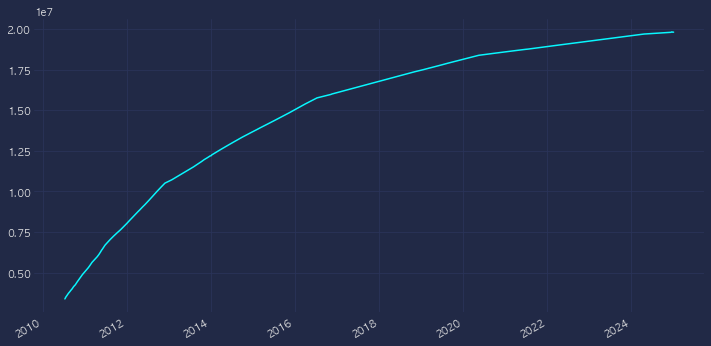

In [122]:
plt.figure(figsize=(12,6))
df['supply'].plot()

<AxesSubplot:>

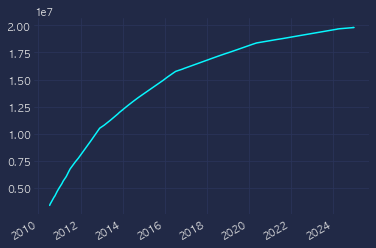

In [127]:
(df['market_cap'] / df['price']).plot()

<AxesSubplot:>

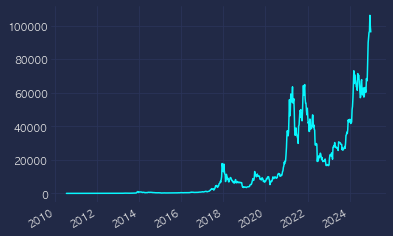

In [124]:
df['price'].plot()

In [107]:
for k, v in bitcoin_price.items():a
    datetime.fromtimestamp(int(k))a
    

SyntaxError: invalid syntax (<ipython-input-107-3675f76e89ca>, line 1)

In [89]:
res.json()

{'data': {'points': {'1704326400': {'v': [42855.81476135893,
     30448091209.81,
     839543268384.2833,
     1,
     19589950.0],
    'c': [56151787.749594666, 39894580572415.57, 1100010714425172.0]},
   '1704412800': {'v': [44192.97869877169,
     32336029346.8,
     865776072249.7687,
     1,
     19590806.0],
    'c': [57991882.8417781, 42432695886598.94, 1136107726328003.5]},
   '1704499200': {'v': [44178.95460684357,
     16092503467.55,
     865539720497.032,
     1,
     19591675.0],
    'c': [58084059.674609624, 21157538471456.8, 1137964019825557.5]},
   '1704585600': {'v': [43998.46424256272,
     19330573863.32,
     862036610787.5919,
     1,
     19592425.0],
    'c': [57846760.87062305, 25414775333946.0, 1133358323850617.0]},
   '1704672000': {'v': [43948.70695530909,
     42746192015.18,
     861095805116.7621,
     1,
     19593200.0],
    'c': [57757038.34368458, 56176702849934.65, 1131645203675480.8]},
   '1704758400': {'v': [46987.63874100883,
     39821290991.56,
 

In [58]:
[datetime.fromtimestamp(int(x)) for x in list(res.json()['data']['points'].keys())]

KeyError: 'data'

In [51]:
soup = BeautifulSoup(res.json, 'lxml')
soup

TypeError: object of type 'method' has no len()

In [34]:
import yfinance as yf

In [36]:
gld = yf.Ticker("GLD")

In [47]:
gld.options


()

In [22]:
gdp

1946-01-01          NaN
1946-04-01          NaN
1946-07-01          NaN
1946-10-01          NaN
1947-01-01      243.164
                ...    
2023-07-01    27967.697
2023-10-01    28296.967
2024-01-01    28624.069
2024-04-01    29016.714
2024-07-01    29374.914
Length: 315, dtype: float64

In [27]:
(interest_payments / gdp)['2022']

2022-01-01    0.025266
2022-04-01    0.026543
2022-07-01    0.028651
2022-10-01    0.030844
dtype: float64

In [19]:
fred.search('gross domestic product')

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
GDP,GDP,2025-01-02,2025-01-02,Gross Domestic Product,1947-01-01,2024-07-01,Quarterly,Q,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-12-19 07:55:01-06:00,93,BEA Account Code: A191RC Gross domestic produ...
GDPC1,GDPC1,2025-01-02,2025-01-02,Real Gross Domestic Product,1947-01-01,2024-07-01,Quarterly,Q,Billions of Chained 2017 Dollars,Bil. of Chn. 2017 $,Seasonally Adjusted Annual Rate,SAAR,2024-12-19 07:55:02-06:00,92,BEA Account Code: A191RX Real gross domestic ...
A191RL1Q225SBEA,A191RL1Q225SBEA,2025-01-02,2025-01-02,Real Gross Domestic Product,1947-04-01,2024-07-01,Quarterly,Q,Percent Change from Preceding Period,% Chg. from Preceding Period,Seasonally Adjusted Annual Rate,SAAR,2024-12-19 07:55:03-06:00,74,BEA Account Code: A191RL Gross domestic produ...
GDPA,GDPA,2025-01-02,2025-01-02,Gross Domestic Product,1929-01-01,2023-01-01,Annual,A,Billions of Dollars,Bil. of $,Not Seasonally Adjusted,NSA,2024-09-26 07:47:03-05:00,64,BEA Account Code: A191RC
GDPCA,GDPCA,2025-01-02,2025-01-02,Real Gross Domestic Product,1929-01-01,2023-01-01,Annual,A,Billions of Chained 2017 Dollars,Bil. of Chn. 2017 $,Not Seasonally Adjusted,NSA,2024-09-26 07:47:03-05:00,58,BEA Account Code: A191RX A Guide to the Natio...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INNGSP,INNGSP,2025-01-02,2025-01-02,Gross Domestic Product: All Industry Total in ...,1997-01-01,2023-01-01,Annual,A,Millions of Dollars,Mil. of $,Not Seasonally Adjusted,NSA,2024-09-27 09:08:07-05:00,16,Information about this release can be found he...
NGDPSAXDCITQ,NGDPSAXDCITQ,2025-01-02,2025-01-02,Nominal Gross Domestic Product for Italy,1995-01-01,2024-04-01,Quarterly,Q,Millions of Domestic Currency,Mil. of Domestic Currency,Seasonally Adjusted,SA,2024-10-21 08:37:03-05:00,16,None
KYNGSP,KYNGSP,2025-01-02,2025-01-02,Gross Domestic Product: All Industry Total in ...,1997-01-01,2023-01-01,Annual,A,Millions of Dollars,Mil. of $,Not Seasonally Adjusted,NSA,2024-09-27 09:08:05-05:00,16,Information about this release can be found he...


In [ ]:

# 데이터 가져오기
yield_10y = fred.get_series('DGS10', start_date, end_date)
yield_2y = fred.get_series('DGS2', start_date, end_date)
recession = fred.get_series('USREC', start_date, end_date)

# 금리차 계산 및 데이터프레임 생성
spread = yield_10y - yield_2y
df = pd.DataFrame({'Spread': spread, 'Recession': recession}).dropna()
df['Recession'] = df['Recession'].astype(int)